In [1]:
%matplotlib inline 
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
sns.set_style('ticks')
default_colors = sns.color_palette(); 

# Adjust all text and axes colors to black. default is some studip gray that appears to faint when printed 
from matplotlib import rc , rcParams
rc('axes',edgecolor='black')
rc('xtick',color='black',labelsize=15)
rc('ytick',color='black',labelsize=15)
rc('text',color='black')
rc('axes',labelcolor='black',linewidth=2.0)
rc('font',size=15)
#rcParams["patch.force_edgecolor"] = True



import Calculate_ABA_Finkelsteinlab as CalcABA
reload(CalcABA);


import sys
sys.path.append('../code_Boyle/')
import plotting_Boyle as plt_B
reload(plt_B);

sys.path.append('../code_ABA_Finkelsteinlab/')
import plotting_ABA as pltABA
reload(pltABA);

### Load Parameters

In [2]:
model_id = 'init_limit_general_energies_v2'
filename = '../data/25_10_2018/median_landscape_Boyle.txt'
# filename = '../data/25_10_2018/fit_25_10_2018_sim_40.txt'

boyle_params = np.loadtxt(filename,comments='#')

# Nparams = 44
# boyle_params = plt_B.load_simm_anneal(filename, Nparams)

### Load data

In [3]:
IlyaData = pd.read_csv('../Data_ABA_Finkelsteinlab/champ-cas9-cas12a-data/cas9-target-e-replicate-1-delta-abas-processed.csv')

### Prediction

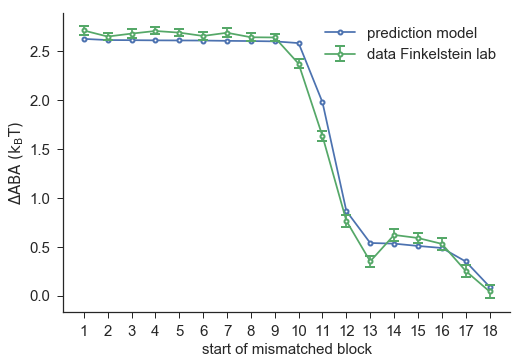

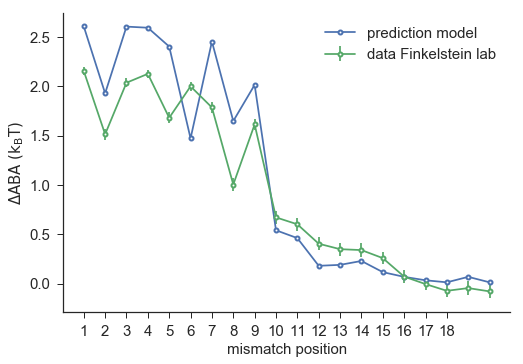

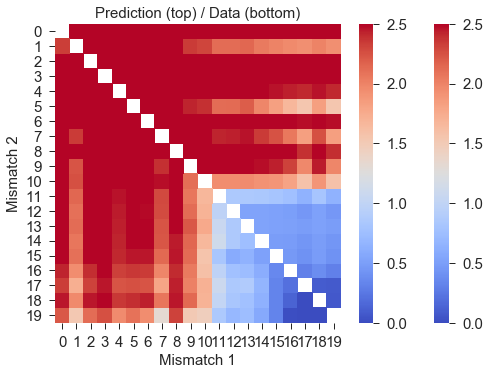

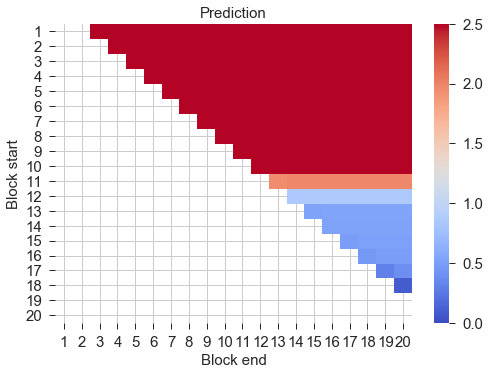

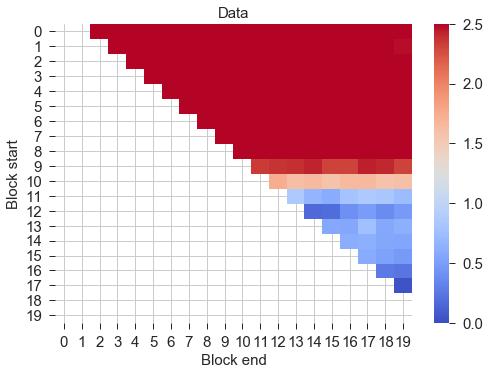

In [5]:
plt.figure()
_ = pltABA.predict_1D_mmblocks(boyle_params, model_id, T=60*10,guide_length=20);
plt.savefig('../reports/fig9_15_11_2018.pdf', format='pdf',bbox_inches='tight')



plt.figure()
_ = pltABA.predict_single_mm(boyle_params,model_id)
plt.savefig('../reports/fig10_15_11_2018.pdf', format='pdf',bbox_inches='tight')


plt.figure()
_ = pltABA.predict_double_mm(boyle_params,model_id)
plt.savefig('../reports/fig11_15_11_2018.pdf', format='pdf',bbox_inches='tight')


plt.figure()
_ = pltABA.predict_block_mismatches(parameters=boyle_params, model_id=model_id, T=60*10,guide_length=20)


# correlation between model and data

In [21]:

# --- data ---
data_1mm= pltABA.plot_single_mut_ABA(data=IlyaData, Mut_type='r', Plot=False)
_, data_2mm = pltABA.plot_double_mut_ABA(data=IlyaData, Mut_type='r', Plot=False)
_, data_blocks, _ = pltABA.plot_block_mm_ABA(IlyaData,Plot=False,SaveFigures=False,figure_names=[''])



#--- model predictions ---- 

model_1mm = pltABA.predict_single_mm(boyle_params,model_id, show_plot=False)
model_2mm = pltABA.predict_double_mm(boyle_params,model_id, show_plot=False)
model_blocks = pltABA.predict_block_mismatches(parameters=boyle_params, model_id=model_id, 
                                               T=60*10,guide_length=20,show_plot=False)


In [110]:
correlate_ABA = pd.DataFrame()
# --- collect all the datapoints ---
data = []
model = []

# --- 2 mismatches ----
for i in range(20):
    for j in range(20):
        if np.isnan(data_2mm[j,i])==False:
            data.append( data_2mm[j,i])
            model.append(model_2mm[j,i])
            
# --- blocks of mismatches -----       
for i in range(20):
    for j in range(20):
        if np.isnan(data_blocks[i,j])==False:
            data.append( data_2mm[j,i])
            model.append(model_2mm[j,i])

# --- single mismatches ----           
data_1mm_array = np.array(data_1mm['Delta ABA (kBT)'])
for i in range(len(data_1mm)):
    data.append(data_1mm_array[i])
    model.append(model_1mm[i])
    
correlate_ABA['data'] = data
correlate_ABA['model'] = model 
x = np.linspace(np.min(data),np.max(data),100)
C = np.corrcoef(data,model)[1][0]


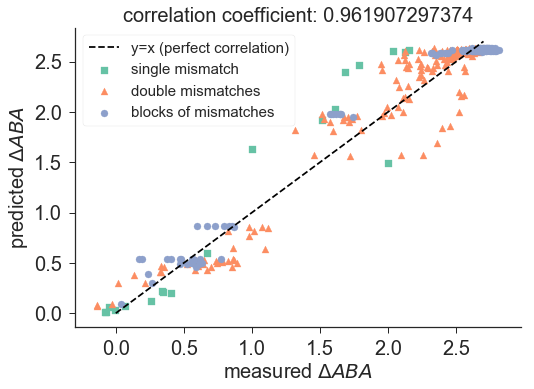

In [116]:
sns.set_palette('Set2')
plt.scatter(data_1mm['Delta ABA (kBT)'],model_1mm, 
            marker='s',
            label='single mismatch')
plt.scatter(data_2mm,model_2mm, 
            marker='^',
            label='double mismatches')
plt.scatter(data_blocks,model_blocks, label='blocks of mismatches');

x = np.linspace(0,2.7,1000);
plt.plot(x,x, linestyle='dashed', color='black', label='y=x (perfect correlation)')
plt.legend(fontsize=15, frameon=True)
plt.xlabel('measured $\Delta ABA$',fontsize=20);
plt.ylabel('predicted $\Delta ABA$',fontsize=20);
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
sns.despine();

C = np.corrcoef(data,model)[1,0]
plt.title('correlation coefficient: ' + str(C) , fontsize=20);